# Data Fit (traditional optimization methods): SIR data without noise

On this notebook, we will use traditional optimization models in order to fit the SIR model on data without noise. The main goal is to obtain the following parameters:

- $\beta$: Contact rate
- $\gamma$: Mean recovery rate

The optimization models used for fitting data are the followings:

## Load data 

In [1]:
# Load Path
import pickle as pkl
data_path = '../../data/raw/simulated/SIR'
with open(f'{data_path}/sir.pkl', 'rb') as f:
    data_sim = pkl.load(f) 

## Division Training/Validation/Test 

Only Test will be used, but in order to compare.

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare data
X = []  # X will be the data from infected people
y = []  # y will be the parameters from that simulation
times = []  # Times for each simulation

for simulation in data_sim:
    compartment_data = simulation[0]  # S, I, R matrix
    parameters = simulation[2]  # [beta, gamma]
    time_steps = simulation[1]  # Times
    
    # Extract I values
    I_values = compartment_data[:, 1]  # Second column (I compartment)
    
    X.append(I_values)  # Add to the characteristic list
    y.append(parameters)  # Add to label list
    times.append(time_steps)  # Add times for each simulation

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
times = np.array(times)

# First division: 90% training + validation, 10% test
_, X_test, _, y_test, _, ts_test = train_test_split(X, y, times, test_size=0.1, random_state=42)

# Print shapes to verify
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("ts_test shape:", ts_test.shape)


X_test shape: (10000, 1001)
y_test shape: (10000, 2)
ts_test shape: (10000, 1001)


## Fitting with data

Using scipy optimize minimize

In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

np.random.seed(15)

# Define SIR model equations
# Definir el modelo SIR
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

# Solve SIR model with odeint
# Resolver el modelo SIR
def solve_sir(S0, I0, R0, beta, gamma, t):
    y0 = [S0, I0, R0]
    solution = odeint(sir_model, y0, t, args=(beta, gamma))
    return solution

# Error function (SSE: Sum of Squared Errors)
def error_function(params, t, data, S0, I0, R0):
    beta, gamma = params
    solution = solve_sir(S0, I0, R0, beta, gamma, t)
    I_model = solution[:, 1]  # Extraer los infectados simulados
    return np.sum((I_model - data)**2)  # Error cuadrático


In [4]:
params_fit = []
y_pred = []
i = 0
for infected, ts, params in zip(X_test, ts_test, y_test):
    print("Fitting simulation", i)
    S0, I0, R0 = 90, 10, 0  # Condiciones iniciales

    beta_init, gamma_init = np.random.uniform(0.1, 3), np.random.uniform(0.1, 1)   # Initial guess for beta and gamma
    result = minimize(
        error_function, 
        [beta_init, gamma_init], 
        args=(ts, infected, S0, I0, R0), 
        bounds=[(0, 3), (0, 1)]  # Restrictions for beta and gamma
    )

    # Extract fitting params
    beta_fit, gamma_fit = result.x
    beta_real, gamma_real = params
    # Compared params
    print("Init params:", beta_init, gamma_init)
    print(f"Fitted params:", beta_fit, gamma_fit)
    print("Real params", beta_real, gamma_real,"\n")

    
    y_pred.append([beta_fit, gamma_fit])
    params_fit.append([i, beta_real, beta_fit, gamma_real, gamma_fit])
    
    i += 1


Fitting simulation 0
Init params: 2.561571322078878 0.26100633242889865
Fitted params: 3.0 1.0
Real params 0.7913167201961155 0.5296031637984128 

Fitting simulation 1
Init params: 0.25765332148865117 0.4253846014794007
Fitted params: 0.0028326068710623825 0.16790199831024658
Real params 0.28326233774501636 0.167902579458222 

Fitting simulation 2
Init params: 0.8986626929585947 0.5770002024058828
Fitted params: 3.0 1.0
Real params 2.3430954897977716 0.8434677440691575 

Fitting simulation 3
Init params: 0.9871648556341563 0.37402692323872877
Fitted params: 2.9999996968812996 0.3427654888483874
Real params 2.443757211976645 0.4005552103722785 

Fitting simulation 4
Init params: 0.42404970090922467 0.3249091124921031
Fitted params: 0.009035583536364694 0.2162918098385852
Real params 0.9035563609752326 0.21629190806137705 

Fitting simulation 5
Init params: 2.761126703726031 0.3377321679280363
Fitted params: 3.0 1.0
Real params 0.9069045877482117 0.8596003211037689 

Fitting simulation 6

In [5]:
y_pred = np.array(y_pred)

from sklearn.metrics import r2_score

r2_combined = r2_score(y_test, y_pred, multioutput='uniform_average')

print(f"Combined R2Score for beta and gamma: {r2_combined}")

Combined R2Score for beta and gamma: -1.57897568402382


In [6]:
y_test,y_pred

(array([[0.79131672, 0.52960316],
        [0.28326234, 0.16790258],
        [2.34309549, 0.84346774],
        ...,
        [1.84105089, 0.58375466],
        [2.97063045, 0.19425141],
        [1.00005171, 0.32324333]]),
 array([[3.00000000e+00, 1.00000000e+00],
        [2.83260687e-03, 1.67901998e-01],
        [3.00000000e+00, 1.00000000e+00],
        ...,
        [3.00000000e+00, 6.77509128e-01],
        [3.00000000e+00, 1.74637277e-01],
        [2.81859113e+00, 3.93612678e-01]]))

In [ ]:
# Save Params 
with open(f'{data_path}/test/params.pkl', 'wb') as f:
    pkl.dump(y_test, f)

In [7]:
# Save Params fitted
with open(f'{data_path}/test/params_fit_minimize.pkl', 'wb') as f:
    pkl.dump(y_pred, f)

Params: [3.         0.99892842]


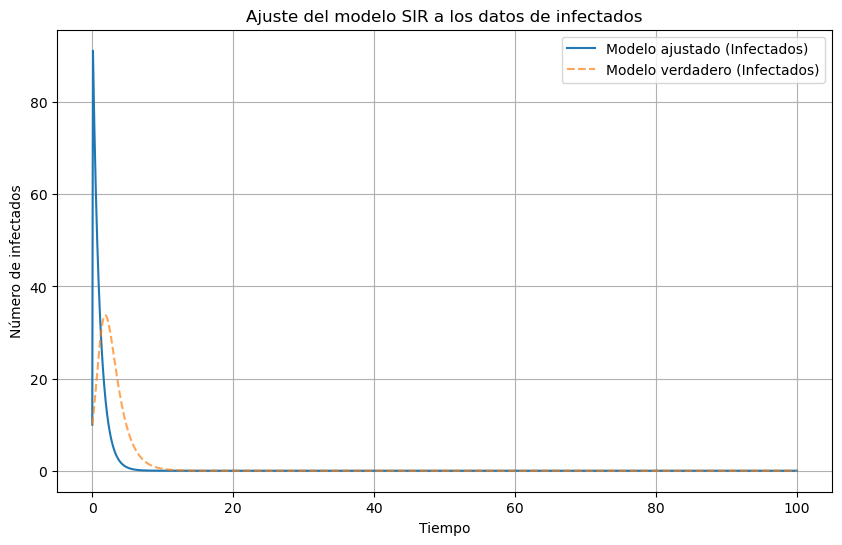

In [11]:
n_sim = 7

# Resolver el modelo con los parámetros ajustados
solution_fit = solve_sir(S0, I0, R0, y_pred[n_sim][0], y_pred[n_sim][1], ts)


print("Params:", y_pred[n_sim])
# Visualizar los resultados
plt.figure(figsize=(10, 6))
# plt.plot(t, I_data, 'o', label='Datos de infectados (observados)', alpha=0.7)
plt.plot(ts, solution_fit[:, 1], '-', label='Modelo ajustado (Infectados)')
plt.plot(ts, X_test[n_sim, :], '--', label='Modelo verdadero (Infectados)', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('Número de infectados')
plt.title('Ajuste del modelo SIR a los datos de infectados')
plt.legend()
plt.grid()
plt.show()